# TOPIC MODELING: 
The following notebook will explain how to use LDA for Topic Modeling. It will include following points:
- cleaning and processing text data
- preparing the text documents to build topic models with scikit learn
- building a basic topic model using LDA 
- extracting the topic’s keywords
- GridSearch and tuning for optimal model
- getting dominant topics in each document
- reviewing and visualizing the topic keywords distribution
- cluster the documents based on topic distribution

## - Input: Text Data as a list
## - Output: 
- Topic Distribution
- Top 15 Keywords
- Original Data classified with Topic Distribution

## - Use Cases:
- Creating categories from free text
- Explore different scenarios with different number of topics
- Extracting key words for each topic
- Clustering of documents



###### Based on guide: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

# Import

## Import Libraries
### Following libraries are required:

In [2]:
import pandas as pd
import numpy as np
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

from pycelonis import get_celonis
from pycelonis.pql import PQL, PQLColumn, PQLFilter

## Login to Celonis

In [3]:
settings = {
    "celonis_url": "https://ml-appstore.eu-1.celonis.cloud/",
    "api_token": "",
}
c = get_celonis(**settings)

2019-12-04 12:55:25 - pycelonis: Login successful! Hello Philippe Büdinger


In [31]:
data_pool = c.pools.find("lda_test")
dm = c.datamodels.find("LDA_test_m")

No exact match, guessed: <Pool, id 8d5b8761-b131-4616-afbe-e96931329c4a, name LDA_test>


No exact match, guessed: <Datamodel, id 14182f83-9841-4416-8e4b-e2613183bc55, name LDA_test_model>


## Pulling Data from Celonis Datamodel
### The data needs to be saved in a variable called "data" as a list object. 

In [27]:
pql = PQL()
for tab in dm.tables:
   if "Test_Data" in tab.name:
       # querying
       query = PQL()
       for colx in tab.columns:
           col_type = colx.get("type")
           col = colx.get("name")
           name = f'{col}'
           cel_name = f'"{tab.data.get("name")}"."{col}"'
           query += PQLColumn(cel_name , name)
t = dm._get_data_frame(query)

                              REASON                       description  \
0  URGENT VILNIUS CUSTOM EO831B003\n   urgent vilnius custom eo831b003   
1   URGENT VILNIUS CUSTOM EP2043B001  urgent vilnius custom ep2043b001   
2    URGENT VILNIUS CUSTOM F501LB001   urgent vilnius custom f501lb001   
3     URGENT VILNIUS CUSTOM F540B014    urgent vilnius custom f540b014   
4     URGENT VILNIUS CUSTOM R017B042    urgent vilnius custom r017b042   

   ticket_id                    description_dl  \
0       5643   urgent vilnius custom eo831b003   
1       3823  urgent vilnius custom ep2043b001   
2      35240   urgent vilnius custom f501lb001   
3      19302    urgent vilnius custom f540b014   
4      15411    urgent vilnius custom r017b042   

                     description_ml    _CELONIS_CHANGE_DATE  
0   urgent vilnius custom eo831b003 2019-12-04 09:17:32.785  
1  urgent vilnius custom ep2043b001 2019-12-04 09:17:32.785  
2   urgent vilnius custom f501lb001 2019-12-04 09:17:32.785  
3    u

In [37]:
data = t["REASON"].values.tolist()
data[:5]

['URGENT VILNIUS CUSTOM EO831B003\n',
 'URGENT VILNIUS CUSTOM EP2043B001',
 'URGENT VILNIUS CUSTOM F501LB001',
 'URGENT VILNIUS CUSTOM F540B014',
 'URGENT VILNIUS CUSTOM R017B042']

# Data Preprocessing

## Regex
### Filter all unwanted characters out with a fitting regex statement

In [38]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:5])

<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \s
<ipython-input-38-514785e75049>:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data]
<ipython-input-38-514785e75049>:5: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['URGENT VILNIUS CUSTOM EO831B003 ',
 'URGENT VILNIUS CUSTOM EP2043B001',
 'URGENT VILNIUS CUSTOM F501LB001',
 'URGENT VILNIUS CUSTOM F540B014',
 'URGENT VILNIUS CUSTOM R017B042']


## Tokenizing
### Tokenizing the with regex cleaned data. Each word of each sentence in the list gets seperated by a ",".

In [39]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))

print(data_words[:10])

[['urgent', 'vilnius', 'custom', 'eo'], ['urgent', 'vilnius', 'custom', 'ep'], ['urgent', 'vilnius', 'custom', 'lb'], ['urgent', 'vilnius', 'custom'], ['urgent', 'vilnius', 'custom'], ['urgent', 'vilnius', 'custom', 'samples', 'samplevnoxx'], ['urgent', 'vilnius', 'custom', 'sku'], ['urgent', 'vilnius', 'custom', 'sku'], ['urgent', 'vilnius', 'custom', 'sku'], ['urgent', 'vilnius', 'custom', 'sku', 'ku']]


## Lemmatization
### Generate the root for each word

In [5]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['refer eco raw material generate customer specific sku', 'necessary pc part cco']


## Document Word Matrix
### Generates a Matrix which represents the occurance of every word in every document

In [6]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=2,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{1,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

## Sparsicity
### Sparsity returns the percentage of Non-Zero cells

In [7]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.08995710421740999 %


# LDA Model

## Build LDA Model

In [8]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


## Evaluate Performance
### Two ways to compare different models: log likelyhood (the higher the better) and perplexity (the lower the better)

In [9]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1074745.1181775846
Perplexity:  1025.3261248678145
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## Gridsearch to find out optimal number of topics
### "topics_number" defines the different number of topics you want to test

In [10]:
# Define Search Param
topics_number = [5,10,15]
search_params = {'n_components': topics_number, 'learning_decay': [.7, .8, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state=100)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, n_jobs = -1)

# Do the Grid Search
model.fit(data_vectorized)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
           

## Best model
### Returns the results of your GridSearch

In [11]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -362991.4893241763
Model Perplexity:  771.5123007701812


## Compare LDA Model Performances

In [12]:
results = pd.DataFrame(model.cv_results_)
results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,90.543397,2.609887,4.294042,0.217953,0.7,5,"{'learning_decay': 0.7, 'n_components': 5}",-353393.489042,-364518.404552,-371063.185269,-362991.489324,7293.934706,1
1,76.063966,2.329690,3.729892,0.043637,0.7,10,"{'learning_decay': 0.7, 'n_components': 10}",-362185.087900,-374147.835182,-380605.146393,-372312.480620,7631.079390,4
2,73.694872,1.171905,3.704757,0.043087,0.7,15,"{'learning_decay': 0.7, 'n_components': 15}",-368113.618443,-380290.449842,-387410.413593,-378604.605143,7967.518906,7


## Visualization of LDA Model Performances

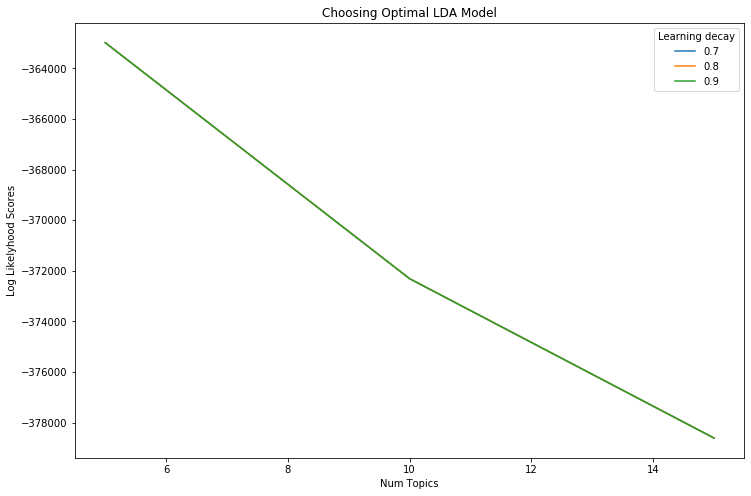

In [13]:
# Get Log Likelyhoods from Grid Search Output
n_topics = topics_number

log_likelyhoods_7 = []
log_likelyhoods_8 = []
log_likelyhoods_9 = []
for index, row in results.iterrows():
    if row.param_learning_decay == 0.7:
        log_likelyhoods_7.append(round(row.mean_test_score)) 
    if row.param_learning_decay == 0.8:
        log_likelyhoods_8.append(round(row.mean_test_score)) 
    if row.param_learning_decay == 0.9:
        log_likelyhoods_9.append(round(row.mean_test_score)) 
        
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_8, label='0.8')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Dominant Topic in each Document (based on best LDA model)

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.14,0.63,0.02,0.19,0.02,1
Doc1,0.05,0.05,0.05,0.05,0.8,4
Doc2,0.24,0.04,0.24,0.04,0.44,4
Doc3,0.05,0.8,0.05,0.05,0.05,1
Doc4,0.03,0.87,0.03,0.03,0.03,1
Doc5,0.37,0.36,0.03,0.2,0.03,0
Doc6,0.61,0.04,0.27,0.04,0.04,0
Doc7,0.2,0.2,0.2,0.2,0.2,0
Doc8,0.04,0.04,0.24,0.23,0.45,4
Doc9,0.04,0.04,0.31,0.04,0.56,4


## Topic Distribution across documents (based on best LDA model)

In [15]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,0,9837
1,2,8620
2,1,8014
3,3,6809
4,4,6358


### Calculates the Topic Distribution across documents where the dominant topic is higher than the threshold

In [16]:
threshold = 0.5
df_document_topic_threshold = df_document_topic[(df_document_topic["Topic0"] > threshold) | (df_document_topic["Topic1"] > threshold) | 
                                                (df_document_topic["Topic2"] > threshold) | (df_document_topic["Topic3"] > threshold) | 
                                                (df_document_topic["Topic4"] > threshold)]
df_topic_distribution2 = df_document_topic_threshold['dominant_topic'].value_counts().reset_index(name="Num Documents in Threshold")
df_topic_distribution2.columns = ['Topic Num2', 'Num Documents in Threshold']
df_topic_distribution2

,Topic Num2,Num Documents in Threshold
0,2,6748
1,1,6330
2,3,5567
3,4,5137
4,0,4208


In [17]:
df_topic_distribution_combined = pd.merge(df_topic_distribution, df_topic_distribution2,
                                         left_on="Topic Num", right_on="Topic Num2", how ="inner")
df_topic_distribution_combined = df_topic_distribution_combined[["Topic Num", "Num Documents", "Num Documents in Threshold"]]
df_topic_distribution_combined


,Topic Num,Num Documents,Num Documents in Threshold
0,0,9837,4208
1,2,8620,6748
2,1,8014,6330
3,3,6809,5567
4,4,6358,5137


### OUTPUT: Topic Distribution

In [18]:
df_topic_distribution_combined.to_excel("5 Topics Topic Distribution.xlsx")

## Visualization of LDA model

In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/jovyan/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      199.643814  -75.004219       1        1  23.900687
1      -58.225704 -153.178375       2        1  21.572289
3      100.112793   33.385571       3        1  19.162750
4       83.945259 -157.750107       4        1  18.595479
0      -35.615849   -7.771173       5        1  16.768796, topic_info=     Category         Freq     Term        Total  loglift  logprob
2401  Default  3878.000000      new  3878.000000  30.0000  30.0000
4016  Default  3772.000000   update  3772.000000  29.0000  29.0000
3496  Default  1631.000000      sku  1631.000000  28.0000  28.0000
2868  Default  3173.000000  product  3173.000000  27.0000  27.0000
3177  Default  1530.000000  request  1530.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
3657   Topic5   151.325230    stock   270.219995   1.2058  -5.1463
3498   Topic5   166.610794     skus   340.850276   1.0699  -5.0500
3061   Topic5   194.451360   record   499.108899   0.8430  -4.8955
3485   Topic5   265.514495     site  1265.526498   0.2241  -4.5840
864    Topic5   158.424302     cost   316.293941   1.0943  -5.1004

[301 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1         1  0.996261           ab
5         4  0.988971     abfinity
49        1  0.979935  acquisition
62        1  0.990691       actual
72        1  0.198219          add
...     ...       ...          ...
4140      3  0.982652         want
4158      3  0.978549          web
4164      1  0.988208       weight
4202      4  0.880187        wrong
4202      5  0.115525        wrong

[460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

## Topic's Keywords

In [20]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aav,ab,abbot,abbreviation,abcam,abfinity,abgent,ability,able,abmaint,...,yellow,yield,za,zero,zip,zipkit,ziplock,zoetis,zone,zqm
Topic0,1.759542,0.201904,0.200027,0.200032,0.200612,0.295797,0.200045,0.200021,25.485704,0.316337,...,2.634730,25.752875,0.207122,0.201163,0.201784,2.199965,6.964539,2.198757,0.200014,0.200012
Topic1,0.200015,0.200719,1.600651,2.199727,0.204692,0.200013,0.200034,0.200014,0.202078,0.205660,...,2.011844,6.642296,0.200019,0.200007,5.335050,0.200008,0.203860,0.200006,0.201256,0.206211
Topic2,0.201181,86.194594,0.201944,1.197619,0.200392,0.200196,0.200031,2.440583,0.203030,0.201374,...,3.645475,0.202505,0.200261,0.200579,1.251847,0.200007,0.200013,0.200369,4.194091,0.200009
Topic3,0.639246,0.201099,0.201361,0.200026,7.194294,0.201348,0.222661,5.408834,28.599047,18.895266,...,2.506729,0.201235,2.193293,0.200008,0.200812,0.200009,0.200649,0.200007,0.200011,0.200958
Topic4,0.200017,0.201684,1.796017,0.202597,0.200010,78.102646,2.177228,0.750548,10.510142,14.381362,...,0.201222,0.201088,3.199304,5.198244,6.010507,0.200010,5.430939,0.200861,0.204629,2.192809


## Top 15 Keywords for each Topic

In [21]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,sku,need,transfer,add,product,use,branch,good,extend,size,batch,liquid,supply,custom,site
Topic 1,new,change,material,description,document,require,create,raw,project,release,custom,number,support,label,add
Topic 2,update,release,document,change,process,initial,review,date,test,plan,current,type,validation,line,product
Topic 3,product,request,site,change,customer,vendor,order,discontinue,attach,launch,longer,email,sheet,extension,supplier
Topic 4,bom,remove,incorrect,datum,correct,miss,error,report,document,component,mco,add,agile,set,approval


### OUTPUT: Top 15 Keywords

In [22]:
df_topic_keywords.to_excel("5 Topics 15 Keywords.xlsx")

## Cluster Documents with similar Topics 

In [23]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.35  0.48  0.53  0.43  0.41]
 [-0.11 -0.54  0.79 -0.25 -0.04]]
Perc of Variance Explained: 
 [0.  0.3]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

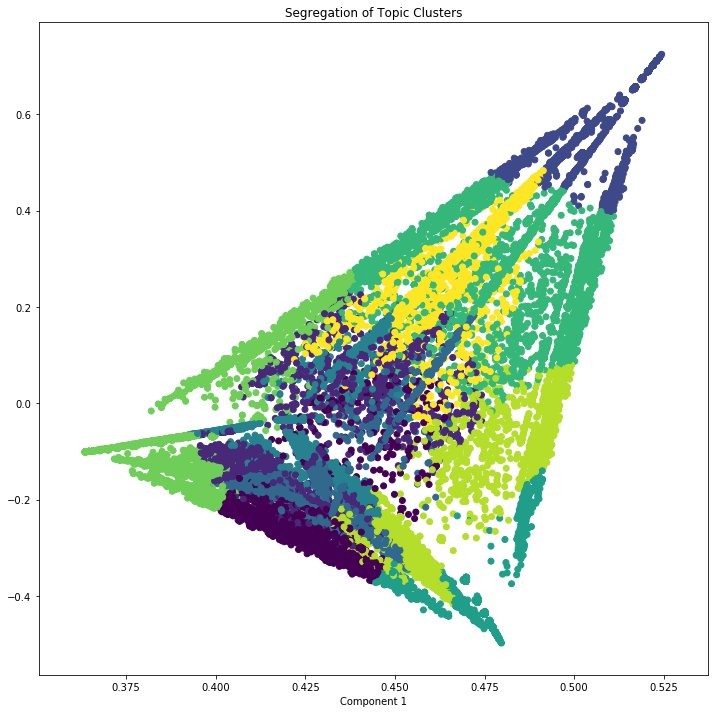

In [24]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### OUTPUT: Original Data with Topic Distribution

In [26]:
df_classification = df_document_topic.reset_index()
df_classification.drop(columns = ["index"], inplace = True)
df_classification.head(3)

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,0.14,0.63,0.02,0.19,0.02,1
1,0.05,0.05,0.05,0.05,0.80,4
2,0.24,0.04,0.24,0.04,0.44,4


In [27]:
df_data= pd.DataFrame(data, columns = ["Raw Data"])
df_rejection_reasons_classified = pd.concat([df_data,df_classification], axis = 1)
df_rejection_reasons_classified.head(3)

,Raw Data,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,Refer to ECO1122616 Raw material being generat...,0.14,0.63,0.02,0.19,0.02,1
1,CMP records necessary for all FG PC Parts. CCO...,0.05,0.05,0.05,0.05,0.80,4
2,This is a memorandum intended to summarize the...,0.24,0.04,0.24,0.04,0.44,4


In [28]:
df_rejection_reasons_classified.to_excel("5 Topics All Rejection Reasons Classified.xlsx")